In [1]:
import os
import numpy as np
from numpy import array
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# from mockfactory import Catalog
from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import KaiserTracerPowerSpectrumMultipoles, TNSTracerPowerSpectrumMultipoles, FOLPSTracerPowerSpectrumMultipoles, FOLPSRCTracerPowerSpectrumMultipoles, FOLPSRUTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.profilers import MinuitProfiler
from desilike.samples import Profiles
from desilike import setup_logging

setup_logging()  # for logging messages

[Macpomme.local:79968] shmem: mmap: an error occurred while determining whether or not /var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T//ompi.Macpomme.501/jf.0/1628307456/sm_segment.Macpomme.501.610e0000.0 could be created.


In [2]:
kmin     = 0.008
kmax     = 0.2
binning  = 0.006
k_ev     = np.arange(kmin, kmax+0.001, binning)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}

# kmin     = 0.0025
# kmax     = 0.3
# binning  = 0.005
# k_ev     = np.arange(kmin, kmax+0.001, binning)
# klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}
# print(k_ev)

systematic_map  = {
    'RSD': '',
    'LRG': '+LRGvsmear',
    'QSO': '+QSOvsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }

In [3]:
# the cosmology parameters
catalogue   = 'fiducial'  # fiducial, Mnu_p, Mnu_ppp -- QUIJOTE catalogue
r_pk        = 'RSD'  # RSD, LRG, QSQ, CATAS-- systematics
CovRsf      = 25  # -- covariance rescale factor
redshift    = 1.0
model       = 'FOLPS' # Kaiser, TNS, FOLPS
systematic = systematic_map.get(r_pk, '')

# Training emulator
emulator_fn = f'./model/emulator_{catalogue}_{model}_z{redshift}.npy'
if not os.path.exists(emulator_fn):
    filename = []
    # filedir = '/home/astro/shhe/projectNU/main/data/halos_kbin0.05/fiducial/RSD_z0.5/npy/'
    filedir = f'/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/{r_pk}_z{redshift}/npy/'
    for file in os.listdir(filedir):
        filename.append(filedir+file)
    covariance = filedir+'*'
    # The template and theory
    cosmo = DESI()
    template = DirectPowerSpectrumTemplate(z=redshift,apmode='qisoqap', fiducial='DESI')
    if catalogue == 'Mnu_p':
        template.init.params['m_ncdm'].update(fixed=False, latex=r'M_\nu', prior = {'limits': [0.0,1.0]}) #we unfix the parameter m_ncdm(Mnu)
        # template.init.params['n_s'].update(fixed=True,value=0.9624)
    if model == 'Kaiser':
        theory = KaiserTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    elif model == 'TNS':
        theory = TNSTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    elif model == 'FOLPS':
        theory = FOLPSTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    observable = TracerPowerSpectrumMultipolesObservable(data= filename,
                                                    covariance= covariance,
                                                    # klim=klim,
                                                    theory=theory,
                                                    kin=k_ev,
                                                    )
    likelihood = ObservablesGaussianLikelihood(observable, scale_covariance = 1/CovRsf) #
    likelihood()
    emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
    emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
    emulator.fit()
    emulator.save(emulator_fn)
    print("Training finished")

In [4]:
# the cosmology parameters
catalogue   = 'fiducial'  # fiducial, Mnu_p, Mnu_ppp -- QUIJOTE catalogue
r_pk        = 'RSD'  # RSD, LRG, QSQ, CATAS-- systematics
CovRsf      = 25  # -- covariance rescale factor
redshift    = 1.0
model       = 'FOLPS' # Kaiser, TNS, FOLPS
systematic = systematic_map.get(r_pk, '')

emulator_fn = f'./model/emulator_{catalogue}_{model}_z{redshift}.npy'
profile_fn = f'./profiler_result/profile_{model}_{r_pk}_V{CovRsf}_z{redshift}.npy'
filename = []
filedir = f'/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/{r_pk}_z{redshift}/npy/'
for file in os.listdir(filedir):
    filename.append(filedir+file)
covariance = filedir+'*'
theory = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
observable = TracerPowerSpectrumMultipolesObservable(data= filename,
                                                    covariance= covariance,
                                                    klim=klim,
                                                    theory=theory,
                                                    kin=np.arange(0.001,0.35,0.002)
                                                    )
likelihood = ObservablesGaussianLikelihood(observable, scale_covariance = 1/25) #
likelihood()
profiler = MinuitProfiler(likelihood, seed=42)
profiles = profiler.maximize()
profiles.save(profile_fn)
print("Profiler finished")
print(profiles.to_stats(tablefmt='pretty'))
likelihood(**profiles.bestfit.choice(input=True))

[000006.19] [0/1] 07-10 16:04  Emulator                  INFO     Loading ./model/emulator_fiducial_FOLPS_z1.0.npy.
[000006.84] [0/1] 07-10 16:04  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/npy/fiducial_122_z1.0.npy, ..., /Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/npy/fiducial_101_z1.0.npy, ..., /Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/npy/fiducial_189_z1.0.npy, ..., /Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/npy/fiducial_141_z1.0.npy, ..., /Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/npy/fiducial_180_z1.0.npy].
[000007.03] [0/1] 07-10 16:04  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/npy/fiducial_100_z1.0.npy, ..., /Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/npy/fiducial_120_z1.0.npy, ..., /Users/alai

Array(-3.78059263, dtype=float64)

In [37]:
H0 = 67.11
delta_vs = np.array([37.2, 85.7, 200])
vs = delta_vs
# vs = np.sqrt(2*delta_vs)

# simgav = [1.0, 1.9, 3.01]
# simgav = [3.5, 3.6]
# vs = (np.array([29.6, 68.3, 159.4]))

zs = np.array([0.5,  1.0,  1.0])
Hz = H0*np.sqrt(0.3175*(1+zs)**3+0.6825)

print((1+zs)/Hz)
sigmavs = vs*(1+zs)/Hz/np.sqrt(2)
print(sigmavs)
print(2*np.pi/sigmavs)

[0.01687647 0.01660146 0.01660146]
[0.44392482 1.00603275 2.34780105]
[14.15371473  6.24550773  2.67620006]


[001124.83] [0/1] 07-10 16:23  Emulator                  INFO     Loading ./model/emulator_fiducial_TNS_z1.0.npy.
[001126.01] [0/1] 07-10 16:23  Profiles                  INFO     Loading ./profiler_result/profile_TNS_RSD_V25_z1.0.npy.
[001126.52] [0/1] 07-10 16:23  Emulator                  INFO     Loading ./model/emulator_fiducial_TNS_z1.0.npy.
[001127.55] [0/1] 07-10 16:23  Profiles                  INFO     Loading ./profiler_result/profile_TNS_RSD_V25_z1.0.npy.
[001127.58] [0/1] 07-10 16:23  Emulator                  INFO     Loading ./model/emulator_fiducial_TNS_z1.0.npy.
[001128.43] [0/1] 07-10 16:23  Profiles                  INFO     Loading ./profiler_result/profile_TNS_RSD_V25_z1.0.npy.


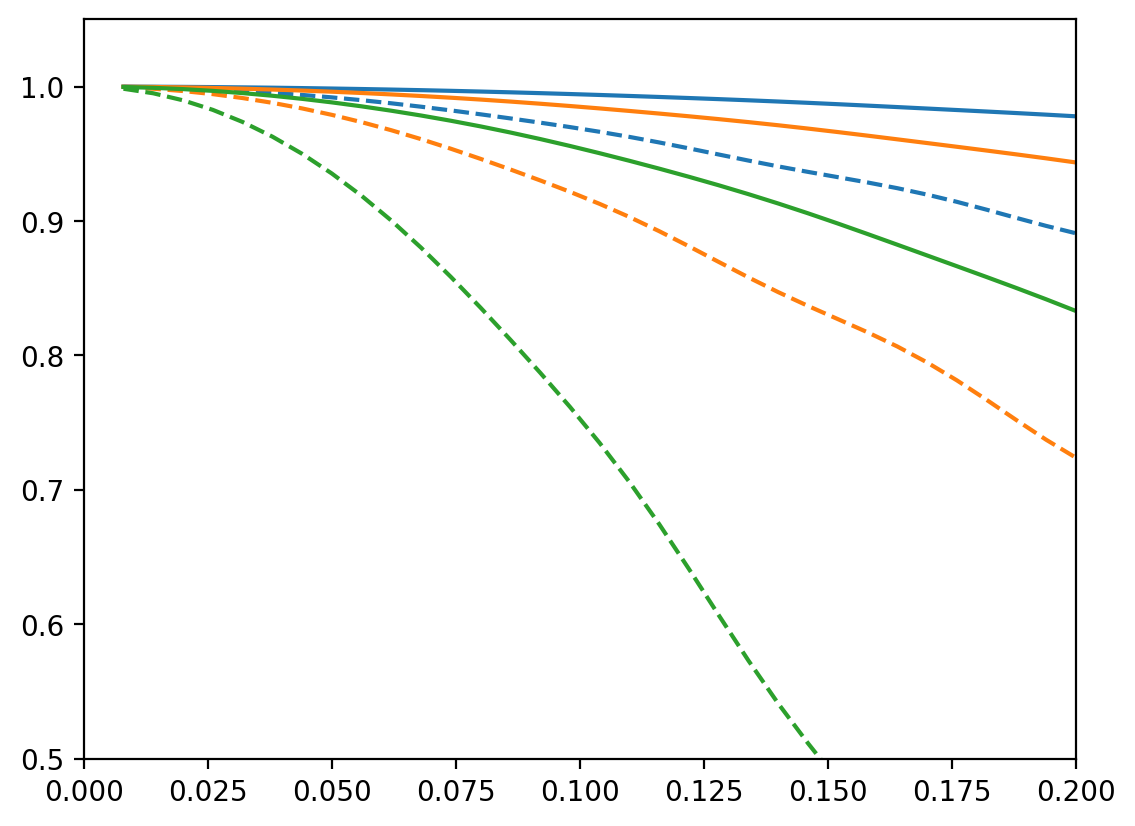

In [38]:
from desilike.theories.galaxy_clustering import FOLPSRUTracerPowerSpectrumMultipoles

r_pk = 'RSD'
model = 'TNS'
ratio_smear = []
for i,v in enumerate(sigmavs):
    if i == 0:
        z = 0.5
    elif i == 1 or i==2:
        z = 1.0
    emulator_fn = f'./model/emulator_{catalogue}_{model}_z{redshift}.npy'
    theory = TNSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
    profile_fn = f'./profiler_result/profile_{model}_{r_pk}_V{CovRsf}_z{redshift}.npy'
    profile = Profiles.load(profile_fn)
    bestfit = profile.bestfit.choice(input=True)
    pkl = theory(bestfit)
    bestfit['sigmav'] += sigmavs[i]
    pkl_smear = theory(bestfit)
    ratio_smear.append([pkl_smear[0]/pkl[0], pkl_smear[1]/pkl[1]])
    plt.plot(k_ev, ratio_smear[i][0], color = f'C{i}')
    plt.plot(k_ev, ratio_smear[i][1], color = f'C{i}', ls= '--')
    plt.xlim([0,0.2])
    plt.ylim([0.5,1.05])

In [39]:
def dataload(data):
    Pk0 = [[],[]]
    Pk2 = [[],[]]
    k = data[0,:,1]
    l0 = data[:,:,3]
    l2 = data[:,:,4]
    Pk0[0] = np.mean(l0,axis=0)
    Pk0[1] = np.std(l0,axis=0)
    Pk2[0] = np.mean(l2,axis=0)
    Pk2[1] = np.std(l2,axis=0)
    pk_cov = np.append(l0,l2,axis=1)
    cov = np.cov(np.array(pk_cov).T)
    # icov = np.linalg.inv(cov)
    return (k,Pk0,Pk2, cov)

def Pkload(catalogue, r_pk, redshift):
    # load the QUIJOTE observation
    tool = 'Pypower' # Powspec, Pypower, NCV
    Ddir = f'/Users/alain/Desktop/projectNU/main/data/kbin2/{catalogue}/{r_pk}_z{redshift}/pk'
    data = []
    nb = np.arange(100,200,1)
    for h in nb:
        realisation=np.loadtxt(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
        data.append(realisation)
    print(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
    (kev, pk0, pk2, icov) = dataload(np.array(data))
    pkl = [kev, pk0, pk2, icov]
    return pkl

/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/LRG_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/LRG_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/QSO_z1.0/pk/fiducial_199_z1.0.pk


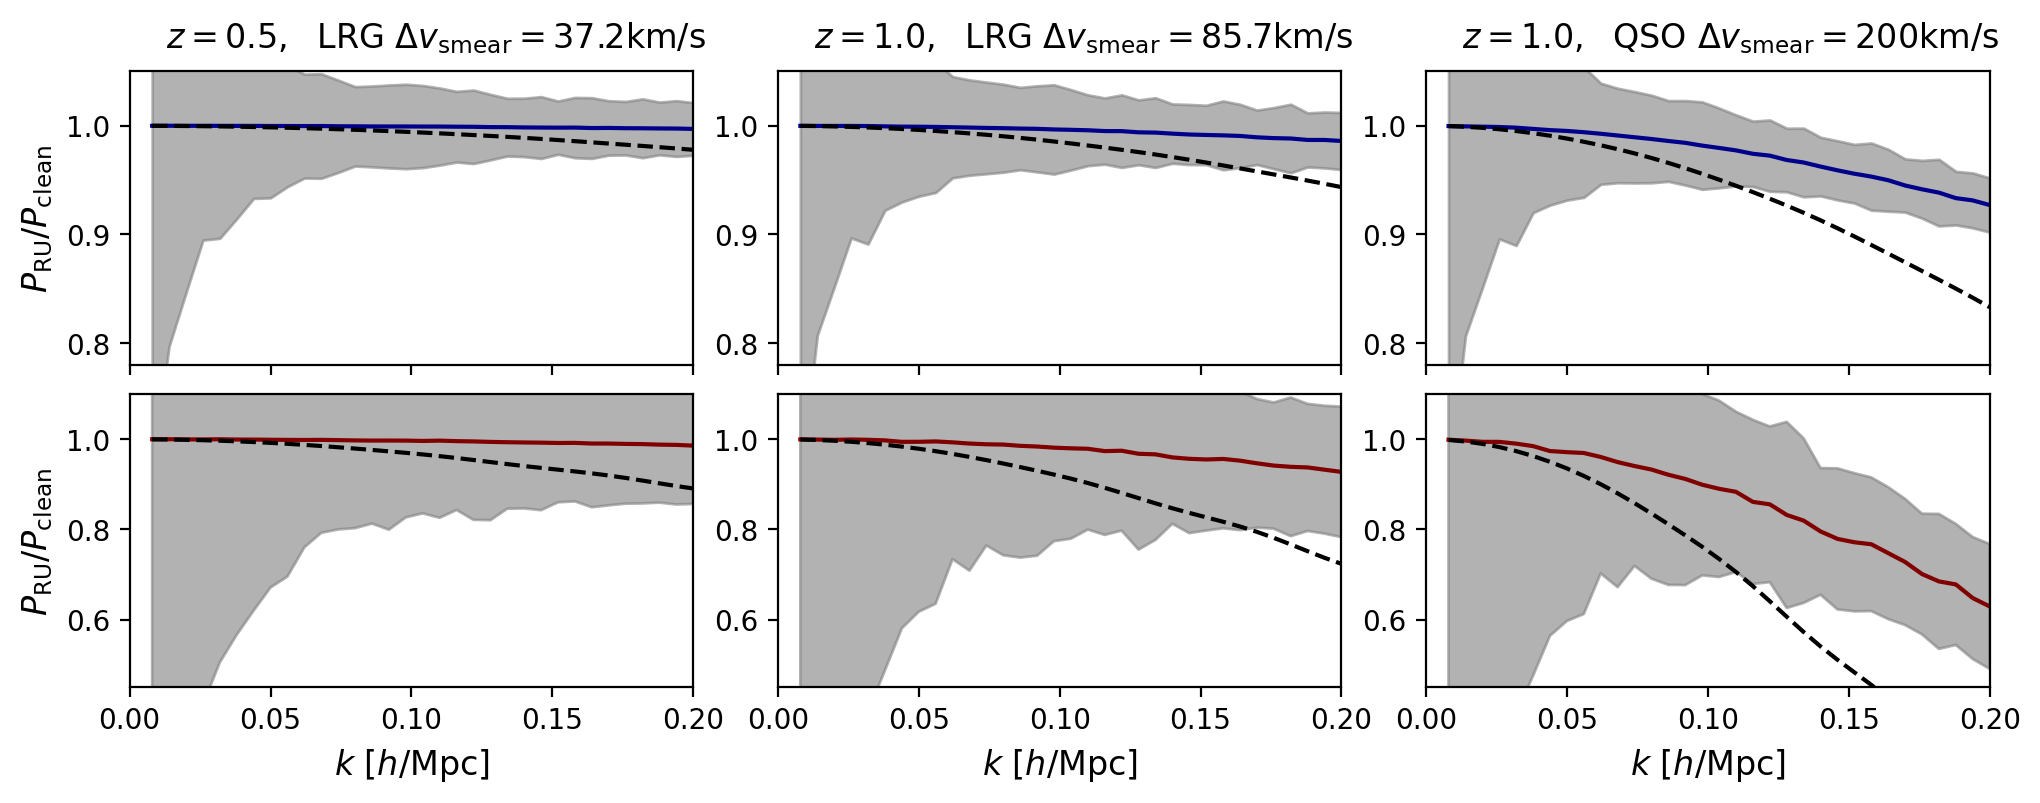

In [40]:
label_fontsize = 12
legend_fontsize = 12
systematic_map  = {
    'RSD': 'fiducial',
    'LRG': '+LRG vsmear',
    'QSO': '+QSO vsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }
fig, axs = plt.subplots(2, 3, sharex=True, sharey=False, figsize = (12, 4))
fig.subplots_adjust(wspace=0.15)
fig.subplots_adjust(hspace=0.1)

colors = ['darkblue', 'maroon']
lss = ['-', '--']

for d in range(3):
    if d == 0:
        z_pk = 0.5
        r_pks = ['RSD', 'LRG']
    elif d == 1:
        z_pk = 1.0
        r_pks = ['RSD', 'LRG']   
    elif d == 2:
        z_pk = 1.0
        r_pks = ['RSD', 'QSO']  

    Pkobs = []
    labels = []
    for t,r_pk in enumerate(r_pks):
        systematic = systematic_map.get(r_pk, '')
        [k_ev, pk0, pk2, cov] = Pkload('fiducial', r_pk, z_pk)
        Pkobs.append([pk0, pk2])
        labels.append(f'obs {systematic}')
        if t == 0:
            rsf = 5
            klen = len(k_ev)
            ref =  [i[0] for i in [pk0, pk2]] 
            errbar = [i[1] for i in [pk0, pk2]]

    for ell, i in zip(['monopole','quadrupole'],range(2)):
        # axs[i][d].axhline(1.0, color='k', linestyle=':', alpha=1.0)
        axs[i][d].plot(k_ev, (Pkobs[1][i][0]/Pkobs[0][i][0]), color = colors[i], linestyle=lss[t-1])
        axs[i][d].fill_between(k_ev,  (Pkobs[t][i][0]-Pkobs[t][i][1])/Pkobs[0][i][0],
                            (Pkobs[1][i][0]+Pkobs[1][i][1])/Pkobs[0][i][0],alpha=0.6, color='grey')
        axs[i][d].plot(k_ev, ratio_smear[d][i], color = 'black', linestyle='--')
        axs[1][d].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize = label_fontsize)
        axs[i][0].set_ylabel(r'$P_{\text{RU}} / P_{\text{clean}} $', fontsize = label_fontsize)
        axs[i][d].set_xlim([0.0,0.20])
        axs[0][d].set_ylim([0.78,1.05])
        axs[1][d].set_ylim([0.45,1.1])

plt.figtext(0.14, 0.91, r'$z=0.5, \ \ \text{LRG} \  \Delta v_{\text{smear}} =  37.2 \rm{km/s}$', fontsize=legend_fontsize)
plt.figtext(0.41, 0.91, r'$z=1.0, \ \ \text{LRG} \  \Delta v_{\text{smear}} =  85.7 \rm{km/s}$', fontsize=legend_fontsize)
plt.figtext(0.68, 0.91, r'$z=1.0, \ \ \text{QSO} \ \Delta v_{\text{smear}} =  200 \rm{km/s}$', fontsize=legend_fontsize)
plt.show()